# SNAC 
### Spiking Neural Autoencoder for time series Compression

This is a main script to test out the idea of Spiking neural networks compression of time series of sensor reads before packing up everyithing in a nice library.

First things first lets load up some sensor readings from an Arduino IoT node!

In [7]:
import numpy as np
import csv, torch
import torch.nn as nn
import torch.nn.functional as F
import snntorch as snn
import snntorch.functional as SF
from snntorch import spikeplot as splt
from snntorch import surrogate
import matplotlib.pyplot as plt

dtype = torch.float

# Check if GPU is selected
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cpu")
# device_name = torch.cuda.get_device_name(device)

# print("Torch device: " + device_name)

# Sensor parameters
sample_period = 10  # ms
recording_length = 1e4  # 1s
n_samples = recording_length / sample_period

ArduinoSensorsCSV = open("ArduinoSensors.csv")
sensor_recording = csv.reader(ArduinoSensorsCSV)
sensor_data = np.array([dataread for dataread in sensor_recording], dtype=np.float32)
# Separate the three sensor readings
acc = sensor_data[:, :3]  # Accelerometer
mag = sensor_data[:, 3:6]  # Magnetometer
gyr = sensor_data[:, 6:]  # Gyroscope

# Let's focus on accelerometer data for now

# Offset data to make sure no inhibition takes place
# There are far more elegant solutions but we
# gotta make it simple for now
acc = acc + 10
acc = torch.tensor(acc, dtype=dtype, device=device)
mean_data = acc.mean().cpu().detach().numpy()

#### Sim Parameters 

Let's define the Autoencoder parameters.

In [18]:
# Network Architecture/Parameters

# Encoder
n_inputs_en = 1
n_hidden_en = 30
# TODO set beta values automatically from freq analysis of data signal.
hid_beta_en = np.logspace(np.log10(0.002), np.log10(0.9), num=n_hidden_en, base=10)
hid_beta_en = torch.tensor(hid_beta_en, dtype=dtype)
hid_thresh_en = 10
n_latent_en = 2
latent_beta_en = mean_data * 1.2
latent_thresh = 0.5

# Decoder
input_beta_de = 0.1
n_hidden_1_de = 30
n_hidden_2_de = 30
n_outputs_de = n_inputs_en

Hidden layer betas act as a frequency decomposition of the input signal, since it defines the response of an RC circuit (the neuron).
Let's do some math to see the actual cutoff frequencies of those betas.

In [3]:
sample_period_seconds = sample_period * 1e-3
taus = -sample_period_seconds / np.log(hid_beta_en)
freqs = 1 / (np.pi * 2 * taus)

print("Hidden Layer Betas in simulation time")
print(hid_beta_en)
print("Hidden Layer Taus in Seconds")
print(taus)
print("Cut-Off Frequencies HZ")
print(freqs)

Hidden Layer Betas in simulation time
tensor([0.0020, 0.0025, 0.0030, 0.0038, 0.0046, 0.0057, 0.0071, 0.0087, 0.0108,
        0.0133, 0.0164, 0.0203, 0.0251, 0.0309, 0.0382, 0.0471, 0.0582, 0.0718,
        0.0887, 0.1095, 0.1352, 0.1668, 0.2060, 0.2543, 0.3139, 0.3875, 0.4784,
        0.5906, 0.7290, 0.9000])
Hidden Layer Taus in Seconds
tensor([0.0016, 0.0017, 0.0017, 0.0018, 0.0019, 0.0019, 0.0020, 0.0021, 0.0022,
        0.0023, 0.0024, 0.0026, 0.0027, 0.0029, 0.0031, 0.0033, 0.0035, 0.0038,
        0.0041, 0.0045, 0.0050, 0.0056, 0.0063, 0.0073, 0.0086, 0.0105, 0.0136,
        0.0190, 0.0316, 0.0949])
Cut-Off Frequencies HZ
tensor([98.9086, 95.5557, 92.2029, 88.8501, 85.4973, 82.1445, 78.7917, 75.4388,
        72.0860, 68.7332, 65.3804, 62.0276, 58.6748, 55.3219, 51.9691, 48.6163,
        45.2635, 41.9107, 38.5579, 35.2050, 31.8522, 28.4994, 25.1466, 21.7938,
        18.4409, 15.0881, 11.7353,  8.3825,  5.0297,  1.6769])


### Network definition

In [38]:
# Define Network
class Net(nn.Module):
    def __init__(self, spike_grad):
        super().__init__()

        # Initialize layers
        # Encoder
        self.lin_1_en = nn.Linear(n_inputs_en, n_hidden_en, bias=False)
        self.lin_1_en.weight.data = torch.ones(self.lin_1_en.weight.size())
        self.lif_1_en = snn.Leaky(
            beta=hid_beta_en,
            threshold=hid_thresh_en,
            spike_grad=spike_grad,
            reset_mechanism="zero",
        )
        self.lin_2_en = nn.Linear(n_hidden_en, n_latent_en, bias=False)
        self.lin_2_en.weight.data = self.lin_2_en.weight.data + 0.1
        self.lif_2_en = snn.Leaky(
            beta=latent_beta_en,
            threshold=latent_thresh,
            spike_grad=spike_grad,
            reset_mechanism="zero",
        )

        # Decoder
        # self.lin_1_de = nn.Linear(n_latent_en, n_hidden_1_de, bias=False)
        # self.lif_1_de = snn.Leaky(
        #     beta=hid_beta_en,
        #     threshold=100000,
        #     spike_grad=spike_grad,
        #     reset_mechanism="zero",
        # )
        self.rnn_1_de = nn.Linear(n_latent_en + n_hidden_1_de, n_hidden_1_de)
        self.sig_1_de = nn.LeakyReLU()
        self.rnn_2_de = nn.Linear(n_hidden_1_de + n_hidden_2_de, n_hidden_2_de)
        self.sig_2_de = nn.LeakyReLU()
        self.lin_output = nn.Linear(n_hidden_2_de, n_outputs_de)
        self.relu_output = nn.LeakyReLU()

    def forward(self, input, t0=True):

        # If we are at t0,
        # initialize hidden states at t=0
        if t0:
            mem_1_en = self.lif_1_en.init_leaky()
            mem_2_en = self.lif_2_en.init_leaky()
            mem_1_de = torch.zeros(3, n_hidden_1_de, device=device)
            mem_2_de = torch.zeros(3, n_hidden_2_de, device=device)

        # Record the last layer
        rec_out = []

        # Also part of the network states for debug
        en_hid_spikes = []
        en_hid_mem = []
        latent_spikes = []
        latent_mem = []

        num_steps = len(input)

        for step in range(num_steps):
            # Encoder
            sum1_en = self.lin_1_en(input[step][:, None])
            spk_1_en, mem_1_en = self.lif_1_en(sum1_en, mem_1_en)
            sum2_en = self.lin_2_en(spk_1_en)
            spk_2_en, mem_2_en = self.lif_2_en(sum2_en, mem_2_en)
            # Decoder
            rnn_input = torch.cat((spk_2_en, mem_1_de), 1)
            mem_1_de = self.rnn_1_de(rnn_input)
            mem_1_de = self.sig_1_de(mem_1_de)
            rnn_input = torch.cat((mem_1_de, mem_2_de), 1)
            mem_2_de = self.rnn_2_de(rnn_input)
            mem_2_de = self.sig_2_de(mem_2_de)
            sum_out = self.lin_output(mem_2_de)
            mem_out = self.relu_output(sum_out)

            # Out Lists
            rec_out.append(mem_out)
            en_hid_spikes.append(spk_1_en)
            en_hid_mem.append(mem_1_en)
            latent_spikes.append(spk_2_en)
            latent_mem.append(mem_2_en)

        return (
            torch.stack(rec_out, dim=0),
            [
                torch.stack(en_hid_spikes, dim=0),
                torch.stack(en_hid_mem, dim=0),
                torch.stack(latent_spikes, dim=0),
                torch.stack(latent_mem, dim=0),
            ],
        )


# The smoothest sigmoid avoids gradient to be zero too far from spike
spike_grad = surrogate.fast_sigmoid(slope=35)
# spike_grad = surrogate.sigmoid(slope=1)

# Load the network onto CUDA if available
net = Net(spike_grad).to(device)

### Run network

In [39]:
loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
# optimizer = torch.optim.SGD(net.parameters(), lr=2e-5)


# Outer training loop
num_epochs = 40000
loss_hist = []

# Outer training loop
for epoch in range(num_epochs):
    # forward pass
    net.train()
    mem_out, hid_monitor = net(acc)
    loss_val = loss(mem_out, acc[:, :, None])

    [en_hid_spikes, en_hid_mem, latent_spikes, latent_mem] = hid_monitor

    sum_en_hid_spikes = np.sum(en_hid_spikes.cpu().detach().numpy(), axis=0)
    sum_latent_spikes = np.sum(latent_spikes.cpu().detach().numpy(), axis=0)

    # Gradient calculation + weight update
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()

    # Store loss history for future plotting
    loss_hist.append(loss_val.item())

    # Print train/test loss/accuracy
    print(f"Iteration: {epoch} \t Train Loss: {loss_val.item()}")
    print(f"Total hidden spikes: {sum_en_hid_spikes}")
    print(f"Total latent spikes: {sum_latent_spikes}")

Iteration: 0 	 Train Loss: 107.6291732788086
Total hidden spikes: [[196. 203. 203. 203. 226. 268. 269. 273. 276. 282. 287. 296. 304. 312.
  322. 330. 340. 343. 353. 363. 371. 378. 380. 382. 383. 383. 386. 386.
  388. 388.]
 [366. 368. 369. 369. 371. 372. 373. 374. 377. 383. 386. 392. 397. 409.
  414. 419. 425. 428. 435. 441. 441. 442. 444. 446. 447. 447. 447. 447.
  447. 447.]
 [430. 431. 431. 431. 431. 431. 431. 432. 432. 433. 435. 437. 437. 441.
  442. 445. 446. 448. 452. 457. 462. 466. 469. 471. 471. 471. 471. 471.
  471. 471.]]
Total latent spikes: [[384. 391.]
 [450. 453.]
 [469. 475.]]
Iteration: 1 	 Train Loss: 107.62743377685547
Total hidden spikes: [[196. 196. 203. 203. 203. 226. 268. 274. 279. 282. 290. 299. 308. 310.
  327. 334. 342. 343. 354. 365. 371. 381. 380. 382. 383. 383. 389. 386.
  388. 388.]
 [366. 366. 368. 368. 369. 371. 372. 379. 381. 386. 391. 395. 400. 407.
  416. 422. 428. 428. 438. 444. 441. 445. 444. 446. 447. 447. 450. 447.
  447. 447.]
 [430. 430. 430. 431

KeyboardInterrupt: 

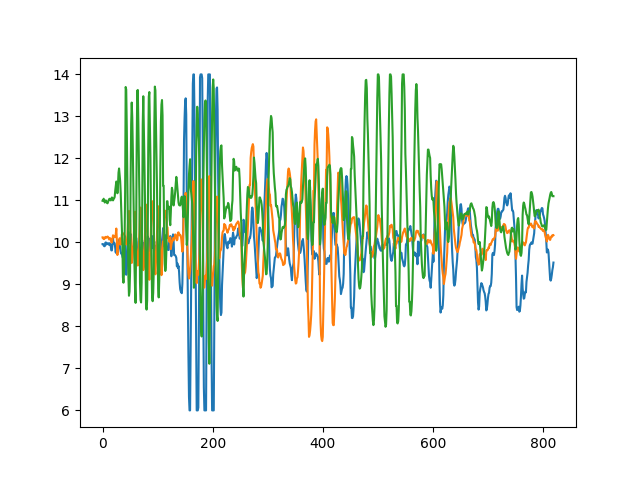

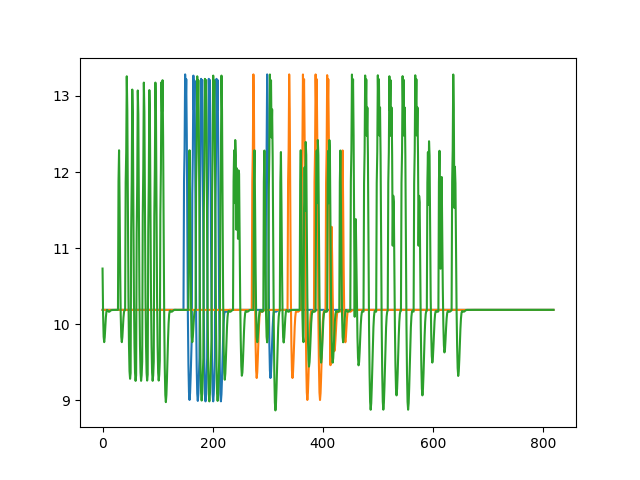

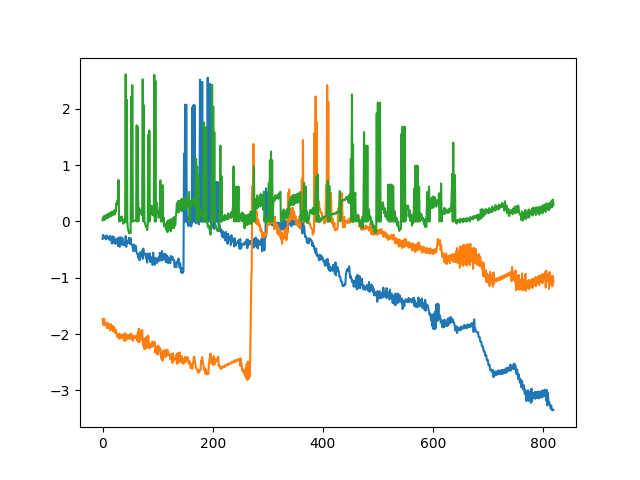

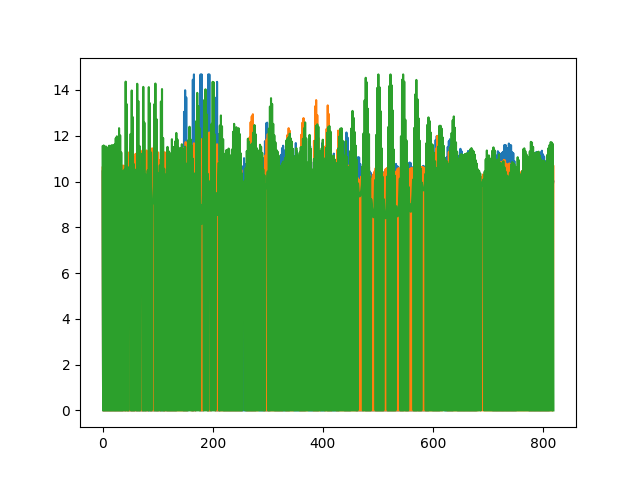

In [40]:
plt.figure()
plt.plot(acc.cpu().detach()[180:,:])

plt.figure()
plt.plot(mem_out.cpu().detach()[180:,:,0])

plt.figure()
plt.plot(latent_mem.cpu().detach()[180:,:,0])

plt.figure()
plt.plot(en_hid_mem.cpu().detach()[180:,:,0])

%matplotlib widget

### Save/Load Network


In [115]:
save_res = "Results/"
# torch.save(net.state_dict(), save_res + "net_best")
net.load_state_dict(torch.load(save_res + "net_best"))

<All keys matched successfully>